# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_balancing_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:

test_data=True
# test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data=data.sample(frac=0.05, replace=False)
    test=test.sample(frac=0.05, replace=False)
    train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)



 
target='returning_user'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19190 entries, 169 to 383728
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   device_category                  19190 non-null  float64
 1   device_mobile_model_name         19190 non-null  float64
 2   device_operating_system          19190 non-null  float64
 3   device_operating_system_version  19190 non-null  float64
 4   device_language                  19190 non-null  float64
 5   device_web_info_browser          19190 non-null  float64
 6   device_web_info_browser_version  19190 non-null  float64
 7   geo_region                       19190 non-null  float64
 8   geo_city                         19190 non-null  float64
 9   traffic_source_medium            19190 non-null  float64
 10  traffic_source_source            19190 non-null  float64
 11  engagement_time_msec             19190 non-null  float64
 12  month               

# Distribution Check

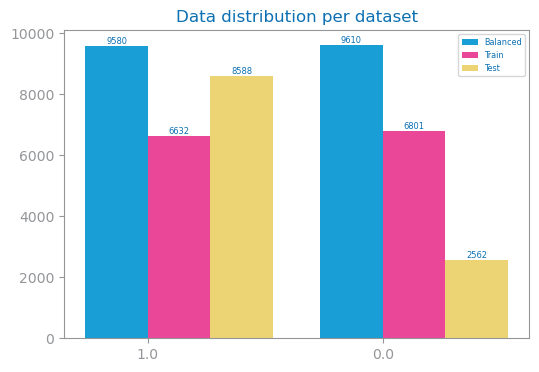

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## DT Evaluate

Train#=13433 Test#=11150
Labels=[0.0, 1.0]
DT best with entropy and d=2


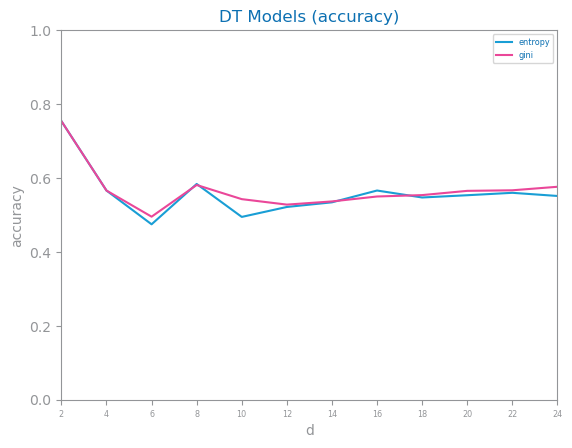

In [6]:
if evaluate==True:

    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

    figure()

    eval_metric = 'accuracy'

    best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
    savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
    show()
    

## DT recall evaluation

DT best with gini and d=6


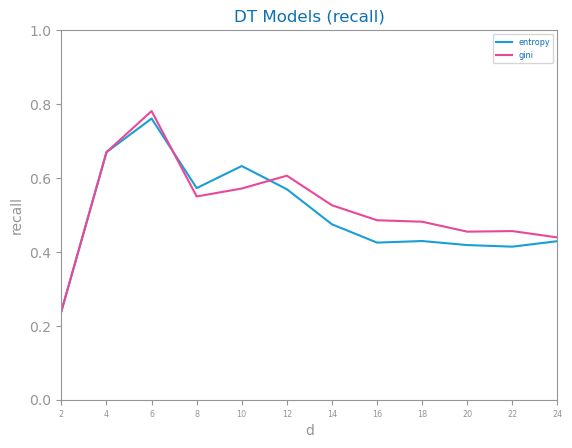

In [7]:
if evaluate==True:

    best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='recall')
    savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
    show()

# Best Model Performance

<Figure size 640x480 with 0 Axes>

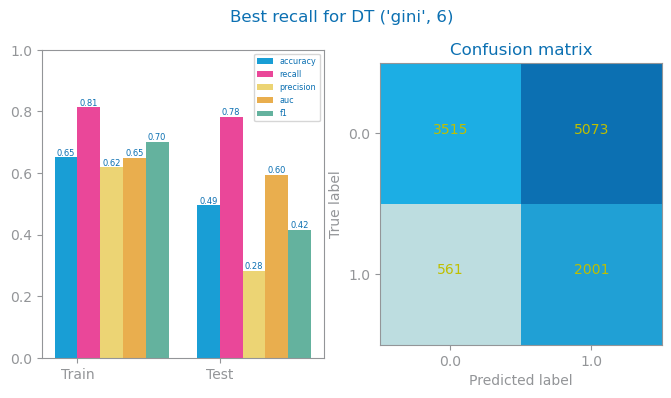

In [8]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

# Variables importance

# IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ

1. open conda terminal
2. conda install graphviz

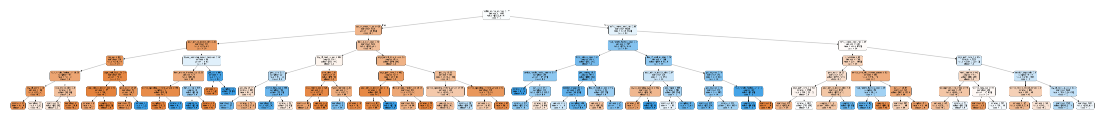

In [9]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

## simpler tree

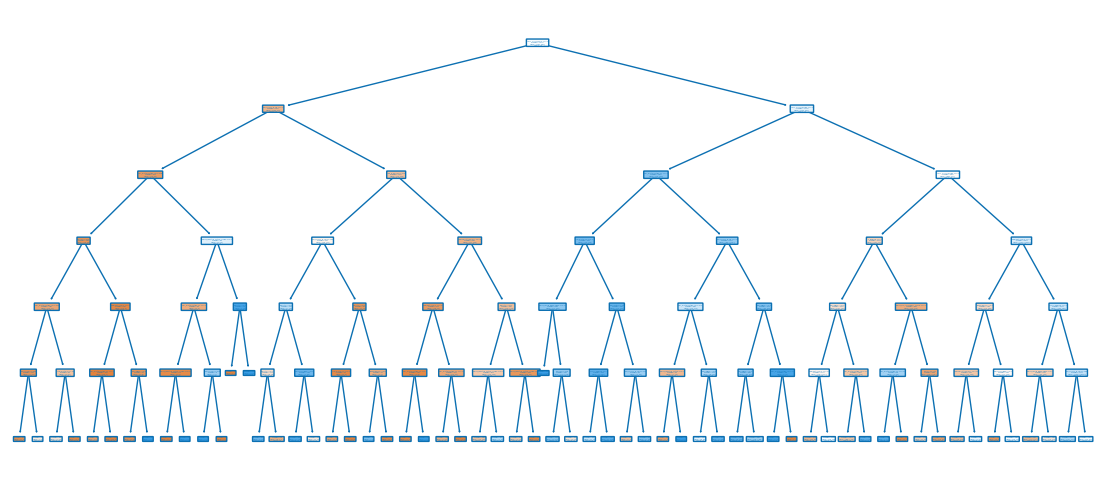

In [12]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")

show()

# Feature Importances

1. traffic_source_medium (0.3133519239991194)
2. traffic_source_source (0.17582551068256005)
3. page_path_level_3 (0.055537059982050455)
4. geo_region (0.052253412380206005)
5. day_of_week_nr_cos (0.049330272747079254)
6. geo_city (0.04211151717679384)
7. session_engaged (0.037657150300541425)
8. hour_minute_fraction_sin (0.034057173041160765)
9. is_weekend (0.03181435465499802)
10. hour_minute_fraction_cos (0.028991046856352367)
11. day_of_week_nr_sin (0.02492950519258627)
12. device_operating_system_version (0.02342503669591405)
13. device_web_info_browser_version (0.020079575661756)
14. time_of_day_cos (0.017885492203416488)
15. engagement_time_msec (0.014437217852411921)
16. device_language (0.011759509862530803)
17. week_number (0.011257194410421272)
18. day_cos (0.009720582425048255)
19. device_mobile_model_name (0.008538018860076303)
20. device_operating_system (0.007840210165938583)
21. day_sin (0.007448132922984816)
22. local_minute_cos (0.006587861282138808)
23. day_of_year (

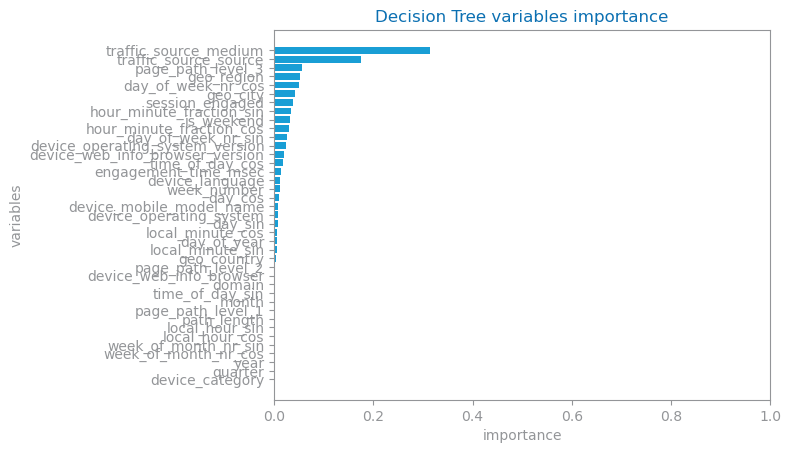

In [13]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")
show()

# Overfitting

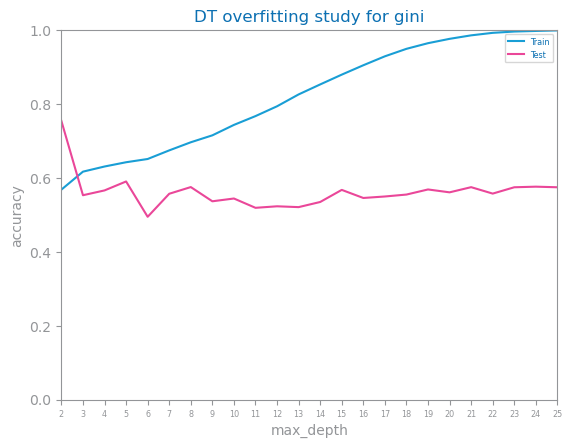

In [14]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")

# Analysis

- Uplift between balancing input approaches is specially significant when it comes to recall (55.7%  out1 to 37% out2). 


# save to csv

In [10]:
if test_data==False:
      
    data_save=apply_strategy_1(data)
        
    data_save.to_csv(f"data/df_merch_7_bal_input.csv", index=False)


    print(data_save.columns)



## train test csv

In [11]:
if test_data==False:
       
    train_save,test_save=simple_split_df(data_save,sort_by='day_of_year')
    
    train_save.to_csv(f"data/df_merch_7_bal_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"data/df_merch_7_bal_input_test.csv", index=False)
    print(test.columns)